<a href="https://colab.research.google.com/github/aru456/btp-thesis/blob/main/LeakyRELU(WGAN_ped1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import os, cv2, csv, random, time, keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import GaussianNoise, Conv2D, Conv2DTranspose, BatchNormalization, Flatten, Dense, Reshape, UpSampling2D, LeakyReLU, Input, Activation
import matplotlib.pyplot as plt
from math import log10, sqrt
from statistics import mean

## Utility Functions

In [ ]:
""" If Need to load from main folder """


def minMaxNormalisation(img):
  mn = img.min()
  mx = img.max()
  img = img.astype('float64')
  img = (img-mn)/(mx-mn)
  return img

def loadFrames(folderPath, resizedShape):

  trainPath = folderPath + 'Testing_videos'
  testPath = folderPath + 'Training_videos'

  trainImages = []
  os.chdir(trainPath)
  trainFolders = os.listdir(trainPath)
  trainFolders.sort()

  for folder in trainFolders:
    tempPath = os.path.join(trainPath, folder)
    frames = os.listdir(tempPath)
    frames.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) # Sort according to the Frame Number
    for frameName in frames:
      framePath = os.path.join(tempPath, frameName)
      img = cv2.imread(framePath)
      img = cv2.resize(img,resizedShape)
      trainImages.append(img)

  trainImages = np.asarray(trainImages)
  trainImages = trainImages.astype('float64')


  testImages = []
  testFolders = os.listdir(testPath)
  testFolders.sort()
  testImageNames = []

  for folder in testFolders:

      tempPath = os.path.join(testPath, folder)
      frames = os.listdir(tempPath)
      frames.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) # Sort according to the Frame Number - https://stackoverflow.com/questions/33159106/sort-filenames-in-directory-in-ascending-order

      for frameName in frames:
        framePath = os.path.join(tempPath, frameName)
        img = cv2.imread(framePath)
        img = cv2.resize(img, resizedShape)
        testImages.append(img)
        testImageNames.append(folder+"_"+frameName)

  testImages = np.asarray(testImages)
  testImages = testImages.astype('float64')

  return trainImages, testImages, testImageNames

folderPath = '/content/drive/MyDrive/1_BTP/Avenue_Dyn/'
resizedShape = (160,160)
trainImages, testImages, testImageNames = loadFrames(folderPath, resizedShape)

for i in range(trainImages.shape[0]):
  trainImages[i] = minMaxNormalisation(trainImages[i])

for i in range(testImages.shape[0]):
  testImages[i] = minMaxNormalisation(testImages[i])

In [ ]:
""" For Loading directly the numpy arrays, the values are between 0 and 1 """


folderPath = '/content/drive/MyDrive/1_BTP/Processed Datasets/UCSD_Ped1/'

fileName = os.path.join(folderPath, 'Dyn8_Train.npy')
trainImages = np.load(fileName)

fileName = os.path.join(folderPath, 'Dyn8_Test.npy')
testImages = np.load(fileName)

fileName = os.path.join(folderPath, 'Dyn8_Test_Names.npy')
testImageNames = np.load(fileName)

FileNotFoundError: ignored

In [ ]:
def getCustomDist(targetFrame, predictedFrame):

  avgFrame = (targetFrame + predictedFrame)/2

  targetFrame[targetFrame == 0.0] = 10E-8 # Replace zero with a small number
  predictedFrame[predictedFrame == 0.0] = 10E-8 # Replace zero with a small number as we can't calculate log of zero

  targetTemp = np.divide(targetFrame, avgFrame)
  predTemp = np.divide(predictedFrame, avgFrame)

  targetLogFrame = np.log2(targetTemp)
  predLogFrame = np.log2(predTemp)

  multTarget = np.multiply(targetFrame, targetLogFrame)
  multPred = np.multiply(predictedFrame, predLogFrame)

  diff = np.subtract(multPred, multTarget)
  dist = np.nansum(diff, axis = (0,1)) # To ignore nan if its in the array

  return dist



In [ ]:
def writeNormsAndPSNR(testImageNames, yTrue, yPredicted, pastCriticValues, futDiscValues, csvFileName):

  # cv2 stores image in bgr method - 'Custom Dist - B','Custom Dist - G','Custom Dist - R',
  fields = ['Frame Name', 'PSNR Value' , 'Custom Dist - Sum',  'Mean Abosolute Diff', 'Mean Squared Diff', 'Past Disc(Pred)', 'Future Disc(Pred)'] # Headers

  rows = []

  yTrue = yTrue.astype('float64')
  yPredicted = yPredicted.astype('float64')

  # MSD = [] # Mean Squared Diff
  # MAD = [] # Mean Absolute Diff
  # psnr = []

  for i in range(yTrue.shape[0]):

    csvRow = []
    csvRow.append(testImageNames[i]) # Append Frame Name

    diff = abs(yTrue[i] - yPredicted[i])
    meanAbsoluteDiff = np.mean(diff)
    # MAD.append(meanAbsoluteDiff)


    meanSquaredDiff = np.mean((diff**2)) # Mean Square Error
    # MSD.append(meanSquaredDiff)

    psnrValue = 100.0
    if(meanSquaredDiff != 0.0):
      max_pixel = 255.0
      psnrValue = 20 * log10(max_pixel / sqrt(meanSquaredDiff))

    #psnr.append(psnrValue)
    tempArr = getCustomDist(yTrue[i], yPredicted[i])

    csvRow.append(psnrValue) # Append PSNR Value

    csvRow.append(np.nansum(tempArr))
    # csvRow.append(tempArr[0])
    # csvRow.append(tempArr[1])
    # csvRow.append(tempArr[2])

    csvRow.append(meanAbsoluteDiff) # Append Mean Absolute Diff Value
    csvRow.append(meanSquaredDiff) # Append Mean Squared Diff Value
    csvRow.append(pastCriticValues[i]) # Append Past Disc Value
    csvRow.append(futDiscValues[i]) # Append Future Disc Value

    rows.append(csvRow)

  with open(csvFileName, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

  print("CSV File Written")

  return

In [ ]:
def plotRandomPrediction(testImages, predictedImages, pltTitle):
  randomIndex = random.randint(0,testImages.shape[0]) # Randomly choose  an index
  fig = plt.figure(figsize=(8,6))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

  ax1.imshow(testImages[randomIndex])
  ax1.set_title('Input image')

  ax2.imshow(predictedImages[randomIndex])
  ax2.set_title('Predicted Image')
  plt.suptitle(pltTitle)
  plt.show()

  return

In [ ]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60)) / 60)
  s = sec_elapsed % 60
  return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# GAN

In [ ]:
# Change the model path
modelPath = "/content/drive/MyDrive/1_BTP/After_MSE/ucsd_ped1/Leakyrelu/"
os.chdir(modelPath)

In [ ]:
def makeEncoder(inputShape, outputUnits):

  # Encoder
  encoder = Sequential()
  encoder.add(GaussianNoise(stddev = 0.2, input_shape = inputShape))

  # Convolution Block
  encoder.add(Conv2D(filters = 64, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  encoder.add(BatchNormalization())
  encoder.add(LeakyReLU(alpha = 0.2))

  # Convolution Block
  encoder.add(Conv2D(filters = 128, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  encoder.add(BatchNormalization())
  encoder.add(LeakyReLU(alpha = 0.2))

  # Convolution Block
  encoder.add(Conv2D(filters = 256, kernel_size = (4,4), strides=(2,2), padding = "same"))
  encoder.add(BatchNormalization())
  encoder.add(LeakyReLU(alpha = 0.2))

  encoder.add(Conv2D(filters = 256, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  encoder.add(BatchNormalization())
  encoder.add(LeakyReLU(alpha = 0.3))

  encoder.add(Flatten())
# encoder.add(Dense(units = 1600))  #Ask if to Add sigmoid activation ????
# encoder.add(Dense(units = 800))
  encoder.add(Dense(units = 1600))

  return encoder

def makeDecoder(inputShape):

  # Decoder

  decoder = Sequential()
  decoder.add(Input(inputShape))
  decoder.add(Reshape((20,20,4)))

  # decoder.add(Conv2DTranspose(filters = 256, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  # decoder.add(BatchNormalization())
  # decoder.add(LeakyReLU(alpha = 0.2))

  # Convolution Block
  decoder.add(Conv2DTranspose(filters = 256, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  decoder.add(BatchNormalization())
  decoder.add(LeakyReLU(alpha = 0.2))

  # Convolution Block
  decoder.add(Conv2DTranspose(filters = 128, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  decoder.add(BatchNormalization())
  decoder.add(LeakyReLU(alpha = 0.2))

  # Convolution Block
  decoder.add(Conv2DTranspose(filters = 64, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  decoder.add(BatchNormalization())
  decoder.add(LeakyReLU(alpha = 0.2))

  # Convolution Block
  decoder.add(Conv2DTranspose(filters = 3, kernel_size = (1,1), strides=(1, 1), padding = "same"))
  decoder.add(BatchNormalization())
  decoder.add(LeakyReLU(alpha = 0.2))

  return decoder

def makeGenerator(input_dim, latent_dim):

  encoder = makeEncoder(input_dim, latent_dim)
  decoder = makeDecoder((latent_dim,))

  input = Input(input_dim)
  encoderOutput = encoder(input)
  reconstruction = decoder(encoderOutput)

  generator = Model(input, reconstruction)

  return generator

In [ ]:
def makeCritic(inputShape):

  # Critic
  critic = Sequential()

  # Convolution Block
  critic.add(Conv2D(filters = 64, kernel_size = (4,4), strides=(2, 2), padding = "same" , input_shape = inputShape))
  critic.add(LeakyReLU(alpha = 0.2))

  # Convolution Block
  critic.add(Conv2D(filters = 128, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  critic.add(BatchNormalization())
  critic.add(LeakyReLU(alpha = 0.2))

  # Convolution Block
  critic.add(Conv2D(filters = 256, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  critic.add(BatchNormalization())
  critic.add(LeakyReLU(alpha = 0.2))

  # Convolution Block
  critic.add(Conv2D(filters = 256, kernel_size = (4,4), strides=(2, 2), padding = "same"))
  critic.add(BatchNormalization())
  critic.add(LeakyReLU(alpha = 0.2))

  critic.add(Flatten())
  critic.add(Dense(units = 1 ))

  return critic

In [ ]:
input_dim = (160,160,3)
latent_dim = 1600
BATCH_SIZE = 25 # As total number of training images are 1906
EPOCHS = 400
clip_value = 0.01
learningRate = 0.00005
trainingDataset = tf.data.Dataset.from_tensor_slices(trainImages).batch(BATCH_SIZE)

In [ ]:
# -1 for real images and 1 for fake(generated) ones

mse = tf.keras.losses.MeanSquaredError()

def past_critic_loss(pastRealOut, pastFakeOut):

    realLoss = tf.math.reduce_mean(np.ones(pastRealOut.shape) * pastRealOut)
    fakeLoss = tf.math.reduce_mean(-np.ones(pastFakeOut.shape) * pastFakeOut)
    totalLoss = realLoss + fakeLoss

    return totalLoss

def future_critic_loss(futureRealOut, futureFakeOut):

    realLoss = tf.math.reduce_mean(-np.ones(futureRealOut.shape) * futureRealOut)
    fakeLoss = tf.math.reduce_mean(np.ones(futureFakeOut.shape) * futureFakeOut)
    totalLoss = realLoss + fakeLoss
    return totalLoss

def generator_loss(futureFakeOut, pastFakeOut, images, generatedImages, lam = 1.0):

    totalLoss = mse(images, generatedImages) # Reconstruction Loss
    return totalLoss

In [ ]:
# Define Models and their optimizers
generatorOptimizer = tf.keras.optimizers.RMSprop(learning_rate=learningRate)
pastCriticOptimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
futureCriticOptimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)

generator = makeGenerator(input_dim, latent_dim)
pastCritic = makeCritic(input_dim)
futureCritic = makeCritic(input_dim)

In [ ]:
checkpoint_prefix = os.path.join(modelPath, "ckpt")
checkpoint = tf.train.Checkpoint(generatorOptimizer = generatorOptimizer, pastCriticOptimizer = pastCriticOptimizer, futureCriticOptimizer = futureCriticOptimizer,
                                generator=generator, pastCritic = pastCritic, futureCritic = futureCritic)

In [ ]:
# To restore a checkpoint
checkpoint.restore(tf.train.latest_checkpoint(modelPath))

## Training

In [ ]:
@tf.function
def train_step(images, clip_value):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as past_disc_tape, tf.GradientTape() as future_disc_tape :

    # [1,2,3,4] => [a,b,c,d]
    generatedImages = generator(images, training = True)

    pastRealOut = pastCritic(images[:-1], training = True) # Real past images are till 2nd last index
    pastFakeOut = pastCritic(generatedImages[1:], training = True)

    futureRealOut = futureCritic(images[1:], training = True) # Real future images are from 2nd index
    futureFakeOut = futureCritic(generatedImages[:-1], training = True)

    # Past Critic Training
    pastCriticLoss = past_critic_loss(pastRealOut, pastFakeOut)
    gradients_of_pastCritic = past_disc_tape.gradient(pastCriticLoss, pastCritic.trainable_variables)
    pastCriticOptimizer.apply_gradients(zip(gradients_of_pastCritic, pastCritic.trainable_variables))

    # Future Critic Training
    futureCriticLoss = future_critic_loss(futureRealOut, futureFakeOut)
    gradients_of_futureCritic = future_disc_tape.gradient(futureCriticLoss, futureCritic.trainable_variables)
    futureCriticOptimizer.apply_gradients(zip(gradients_of_futureCritic, futureCritic.trainable_variables))

    # Generator Training
    genLoss = generator_loss(futureFakeOut, pastFakeOut, images[1:], generatedImages[:-1]) # images[i+1] are the future of images[i] , so generator should produce images[i+1] for image[i]
    gradients_of_generator = gen_tape.gradient(genLoss, generator.trainable_variables)
    generatorOptimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  return genLoss, pastCriticLoss, futureCriticLoss


In [ ]:
def clipWeights():

  # Clip the critic weights
  for l in pastCritic.layers:
    weights = l.get_weights()
    weights = [np.clip(w, -clip_value, clip_value) for w in weights]
    l.set_weights(weights)

  for l in futureCritic.layers:
    weights = l.get_weights()
    weights = [np.clip(w, -clip_value, clip_value) for w in weights]
    l.set_weights(weights)

  return

In [ ]:
# Start time of training
start = time.time()

genLoss = []
pastCriticLoss = []
futureCriticLoss = []

for epoch in range(EPOCHS):

  epochStartTime = time.time()

  generatorLossList = []
  pastCriticLossList = []
  futureCriticLossList = []

  for image_batch in trainingDataset:

    t = train_step(image_batch, clip_value)
    clipWeights()

    generatorLossList.append(t[0])
    pastCriticLossList.append(t[1])
    futureCriticLossList.append(t[2])

  g_loss = sum(generatorLossList) / len(generatorLossList)
  past_dloss = sum(pastCriticLossList) / len(pastCriticLossList)
  future_dloss = sum(futureCriticLossList) / len(futureCriticLossList)

  genLoss.append(g_loss)
  pastCriticLoss.append(past_dloss)
  futureCriticLoss.append(future_dloss)

  timeElapsed = time.time()-epochStartTime
  print ("Epoch = {}, Gen Loss = {:.5f}, Past Disc Loss = {:.7f}, Future Disc Loss = {:.7f} ".format(epoch+1, g_loss, past_dloss, future_dloss) + "Epoch Time : " + hms_string(timeElapsed))

  # Save at each 25 epochs
  if((epoch+1)%50==0):
    checkpoint.save(file_prefix = checkpoint_prefix)
    print("Models saved at {} epochs".format(epoch+1))


elapsed = time.time()-start
print ("Total Training time: " + hms_string(elapsed))

Epoch = 1, Gen Loss = 0.12126, Past Disc Loss = 0.0273106, Future Disc Loss = -0.0116399 Epoch Time : 0:00:39.77
Epoch = 2, Gen Loss = 0.07121, Past Disc Loss = -0.0000235, Future Disc Loss = -0.0000260 Epoch Time : 0:00:22.43
Epoch = 3, Gen Loss = 0.06578, Past Disc Loss = -0.0000212, Future Disc Loss = -0.0000349 Epoch Time : 0:00:22.52
Epoch = 4, Gen Loss = 0.06313, Past Disc Loss = -0.0000225, Future Disc Loss = -0.0000427 Epoch Time : 0:00:22.99
Epoch = 5, Gen Loss = 0.06175, Past Disc Loss = -0.0000249, Future Disc Loss = -0.0000527 Epoch Time : 0:00:22.94
Epoch = 6, Gen Loss = 0.06070, Past Disc Loss = -0.0000284, Future Disc Loss = -0.0000662 Epoch Time : 0:00:22.93
Epoch = 7, Gen Loss = 0.05982, Past Disc Loss = -0.0000328, Future Disc Loss = -0.0000808 Epoch Time : 0:00:23.07
Epoch = 8, Gen Loss = 0.05912, Past Disc Loss = -0.0000377, Future Disc Loss = -0.0000977 Epoch Time : 0:00:22.88
Epoch = 9, Gen Loss = 0.05828, Past Disc Loss = -0.0000422, Future Disc Loss = -0.0001158

## Testing

In [ ]:
def minMaxNormalisation(img):
  mn = img.min()
  mx = img.max()
  img = img.astype('float64')
  img = (img-mn)/(mx-mn)
  return img

In [ ]:
predictedImages  = generator.predict(testImages)

In [ ]:
for i in range(predictedImages.shape[0]):
  predictedImages[i] = minMaxNormalisation(predictedImages[i])

<Figure size 576x432 with 0 Axes>

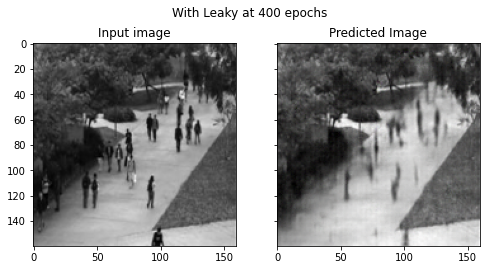

<Figure size 576x432 with 0 Axes>

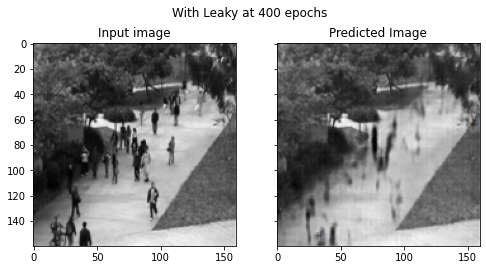

<Figure size 576x432 with 0 Axes>

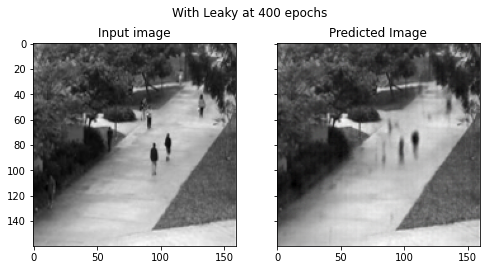

<Figure size 576x432 with 0 Axes>

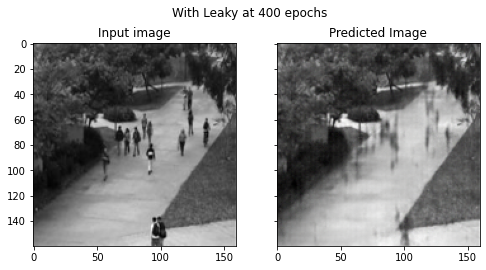

<Figure size 576x432 with 0 Axes>

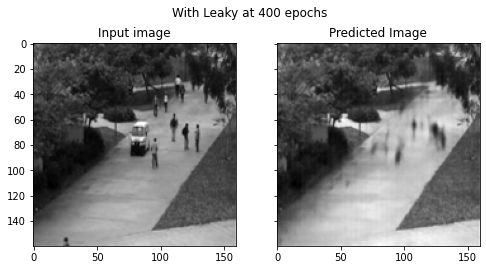

In [ ]:
for i in range(5):
  plotRandomPrediction(testImages, predictedImages, "With Leaky at 400 epochs")

In [ ]:
predicted_Images = generator.predict(trainImages)
for i in range(predicted_Images.shape[0]):
  predicted_Images[i] = minMaxNormalisation(predicted_Images[i])


<Figure size 576x432 with 0 Axes>

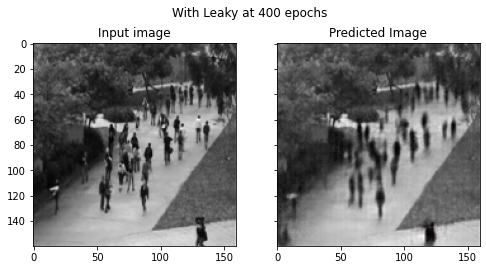

<Figure size 576x432 with 0 Axes>

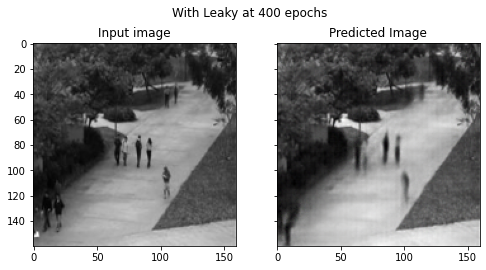

<Figure size 576x432 with 0 Axes>

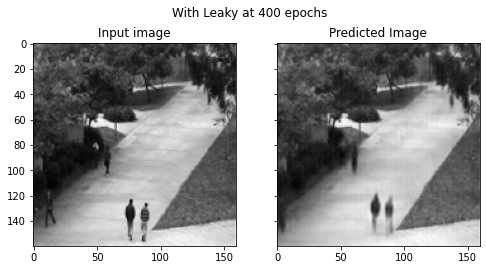

<Figure size 576x432 with 0 Axes>

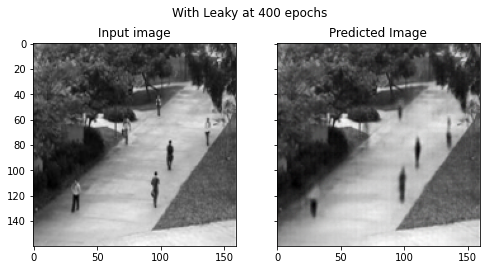

<Figure size 576x432 with 0 Axes>

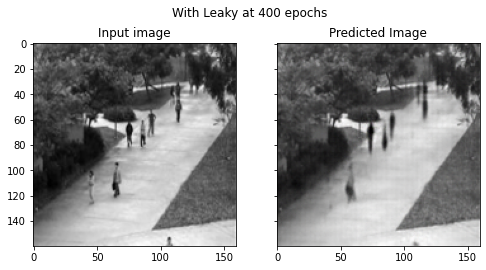

In [ ]:
for i in range(5):
  plotRandomPrediction(trainImages, predicted_Images, "With Leaky at 400 epochs")

In [ ]:
pastCriticValues = tf.keras.activations.sigmoid(pastCritic(predictedImages)).numpy()
futDiscValues = tf.keras.activations.sigmoid(futureCritic(predictedImages)).numpy()

In [ ]:
writeNormsAndPSNR(testImageNames, testImages, predictedImages, pastCriticValues, futDiscValues, "Observation_AED(Tanh-WGAN)_1000.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in subtract


CSV File Written


## Sir's Code

In [ ]:
import scipy
from scipy import signal
from matplotlib import colors
import glob
from PIL import Image, ImageOps
import natsort

In [ ]:
def create_dataset(path, batch_size, shuffle):
  files = natsort.natsorted(filter( os.path.isfile,glob.glob(path + '/T*/*', recursive=True)))
  data = np.zeros((len(files),160,160,3))

  for idx, filename in enumerate(files):
    im = Image.open(filename)
    #im = ImageOps.grayscale(im)
    im = im.resize((160,160))
    data[idx,:,:,:] = np.array(im, dtype=np.float32)/255.0

  dataloader = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)

  return dataloader

# create dataloader (batch_size, 10, 227, 227)
def create_dataset_stacked_images(path, batch_size, shuffle, augment=True):

  files = sorted(glob.glob(path))
  if augment:
    files = files + files[2:] + files[4:] + files[6:] + files[8:]
  data = np.zeros((int(len(files)/10),10,160,160))
  i, idx = 0, 0
  for filename in files:
    im = Image.open(filename)
    im = im.resize((160,160))
    data[idx,i,:,:] = np.array(im, dtype=np.float32)/255.0
    i = i + 1
    if i > 9:
      i = 0
      idx = idx + 1
  dataloader = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)

  return dataloader

In [ ]:
def plot_images(path, model, output_path="img", stacked=False, lstm=False):

  percentAnomaly = []
  if not stacked:
    dataloader = create_dataset(path, batch_size=1, shuffle=False)
  else:
    dataloader = create_dataset_stacked_images(path, batch_size=1, shuffle=False, augment=False)

  counter = 0

  try:
    os.mkdir(output_path)
  except:
    pass

  for image in dataloader:

    image_batch1 = image # Image is already (1,160,160,3)
    reconstructed = model(image_batch1) # Also of (1,160,160,3) format

    reconstructed = reconstructed.numpy()
    reconstructed = minMaxNormalisation(reconstructed)

    #compute difference between reconstructed image and input image
    reconstructed = np.mean(reconstructed, axis = 3) # Getting in grayscale format = (1,160,160)
    image_batch1 = np.mean(image_batch1.numpy(), axis = 3) # Getting in grayscale format = (1,160,160)

    reconstructed = reconstructed.reshape((1,160,160,1)) # As we need 4 dimensions going forward
    image_batch1 = image_batch1.reshape((1,160,160,1))


    diff = np.abs(reconstructed-image_batch1)
    reconstructed = tf.transpose(reconstructed,perm=[0,3,1,2])
    diff=np.transpose(diff,(0,3,1,2))


    if stacked:

       # in case of stacked frames, we need to compute the regularity score per pixel
       image = np.sum(image, axis=1, keepdims=True)
       reconstructed = np.sum(reconstructed, axis=1, keepdims=True)
       diff_max = np.max(diff, axis=1)
       diff_min = np.min(diff, axis=1)
       regularity = diff_max - diff_min
       # perform convolution on regularity matrix
       H = signal.convolve2d(regularity[0,:,:], np.ones((4,4)), mode='same')

    else:

      # perform convolution on diff matrix
      H = signal.convolve2d(diff[0,0,:,:], np.ones((4,4)), mode='same')

    # if neighboring pixels are anamolous, then mark the current pixel
    x,y = np.where(H > 4)

    percentAnomalyImage = (len(x)*100.0) / (H.shape[0]*H.shape[1])
    percentAnomaly.append(percentAnomalyImage)

    # plt input image, reconstructed image and difference between both
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(12, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()

    ax0.imshow(image_batch1[0,:,:,0], cmap=plt.cm.gray, interpolation='nearest')
    ax0.set_title('input image')
    ax1.imshow(reconstructed[0,0,:,:], cmap=plt.cm.gray, interpolation='nearest')
    ax1.set_title('reconstructed image')
    ax2.imshow(diff[0,0,:,:], cmap=plt.cm.viridis, vmin=0, vmax=1, interpolation='nearest')
    ax2.set_title('diff ')
    ax3.imshow(image_batch1[0,:,:,0], cmap=plt.cm.gray, interpolation='nearest')
    ax3.scatter(y,x,color='red',s=0.3)
    ax3.set_title('anomalies')
    plt.axis('off')

    counter = counter + 1
    fig.savefig(output_path + "/" + str(counter) + '.png', bbox_inches = 'tight', pad_inches = 0.5)
    plt.close(fig)

  return percentAnomaly

In [ ]:
# For Training Images
trainingDatasetPath = "/content/drive/MyDrive/1_BTP/UCSD_peds1/Training_videos/*/*"
outputPath = "/content/drive/MyDrive/1_BTP/After_MSE/ucsd_ped1/Results/Leakyrelu(peds1)/Train-img"
percentAnomalyTraining = plot_images(trainingDatasetPath, generator, output_path = outputPath)

In [ ]:
# For Testing Images
testingDatasetPath = "/content/drive/MyDrive/1_BTP/UCSD_peds1/Testing_videos/"
outputPath = "/content/drive/MyDrive/1_BTP/After_MSE/ucsd_ped1/Results/Leakyrelu(peds1)/Test-img"
percentAnomalyTesting = plot_images(testingDatasetPath, generator, output_path = outputPath)

In [ ]:
def writeAnomalyPercentage(percentAnomalyTraining, percentAnomalyTesting, csvFileName):

  fields = ['Percentage Anomaly - Training',  'Percentage Anomaly - Testing'] # Headers

  rows = []
  avgPercentageRow = [mean(percentAnomalyTraining), mean(percentAnomalyTesting) ]
  rows.append(avgPercentageRow)


  for i in range(len(percentAnomalyTraining)): # As percent Anomaly testing is of lower length
    rows.append([percentAnomalyTraining[i], percentAnomalyTesting[i]])

  for i in range(len(percentAnomalyTraining) , len(percentAnomalyTesting)):
    rows.append([None, percentAnomalyTesting[i]])

  with open(csvFileName, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

  print("CSV File Written")

  return

In [ ]:
os.chdir("/content/drive/MyDrive/1_BTP/After_MSE/ucsd_ped1/Results/Leakyrelu(peds1)/")
writeAnomalyPercentage(percentAnomalyTraining, percentAnomalyTesting, "Leaky(400 - WGAN) - Anomaly Percentage.csv")

CSV File Written
